In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def load_and_prepare_data():
    """Load the feature data and prepare it for analysis"""
    df = pd.read_csv('data/events_features_extended.csv')
    df = df.rename({'Unnamed: 0': 'user_id'}, axis=1)
    return df

In [3]:
df = load_and_prepare_data()

In [4]:
df

,user_id,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,view_count,...,int_rec,int_rec_sd,view_to_cart_avg,cart_to_purchase_avg,int_skew,high_spike_flag,rev_per_int,purchase_consistency,pop_cat_consistency,cross_cat_ratio
0,1515915625519380000,44.131042,2.694893,8.004473,297.023819,157.501424,36,0.317543,56,55,...,44.131042,9907.394884,0.616667,0.000000,3.988816,0.0,0.000000,0.000000,0.472222,0.055556
1,1515915625513230000,148.475637,4.510764,2.074016,45.979268,157.501181,3,0.332390,4,3,...,148.475637,4301.005406,0.000000,0.000000,0.707107,0.0,35.157500,0.000000,0.666667,0.000000
2,1515915625519010000,85.436088,24.021674,19.545232,81.364985,157.501111,4,0.055505,7,7,...,85.436088,25990.000019,0.000000,0.000000,1.154701,0.0,0.000000,0.000000,0.500000,0.000000
3,1515915625510740000,157.501076,0.000000,0.000000,0.000000,157.501076,1,1.000000,1,1,...,157.501076,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
4,1515915625519320000,29.892025,6.380198,11.645592,182.527130,157.500509,21,0.164566,36,34,...,29.892025,13338.136911,0.033333,0.000000,1.598882,0.0,0.000000,0.000000,0.333333,0.095238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13348,1515915625610980000,0.111019,0.000778,0.002715,348.901265,0.181782,66,66.000000,102,93,...,0.111019,2.752214,3.622222,1.541667,2.950192,0.0,12.001471,102.000288,0.378788,0.015152
13349,1515915625610990000,0.013669,0.000394,0.000584,147.985436,0.156250,85,85.000000,131,110,...,0.013669,9.497503,2.888889,1.170833,3.511591,0.0,22.543435,143.652731,0.435294,0.011765
13350,1515915625611000000,0.089572,0.000546,0.000612,112.182623,0.127222,70,70.000000,97,91,...,0.089572,0.599000,3.540000,1.200000,3.674598,0.0,0.400309,0.000000,0.385714,0.057143
13351,1515915625611010000,0.009387,0.000876,0.002275,259.542344,0.087384,90,90.000000,160,147,...,0.009387,1.617989,2.554167,4.466667,3.948167,0.0,0.094250,0.000000,0.511111,0.022222


In [5]:
def create_correlation_matrix_plot(df):
    """Create and save correlation matrix heatmap"""
    plt.figure(figsize=(20, 16))
    correlation_matrix = df.corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix), k=1)
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                cmap='RdBu_r',
                vmin=-1, 
                vmax=1,
                center=0,
                square=True,
                annot=False,
                fmt='.2f',
                linewidths=0.5)
    
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return correlation_matrix

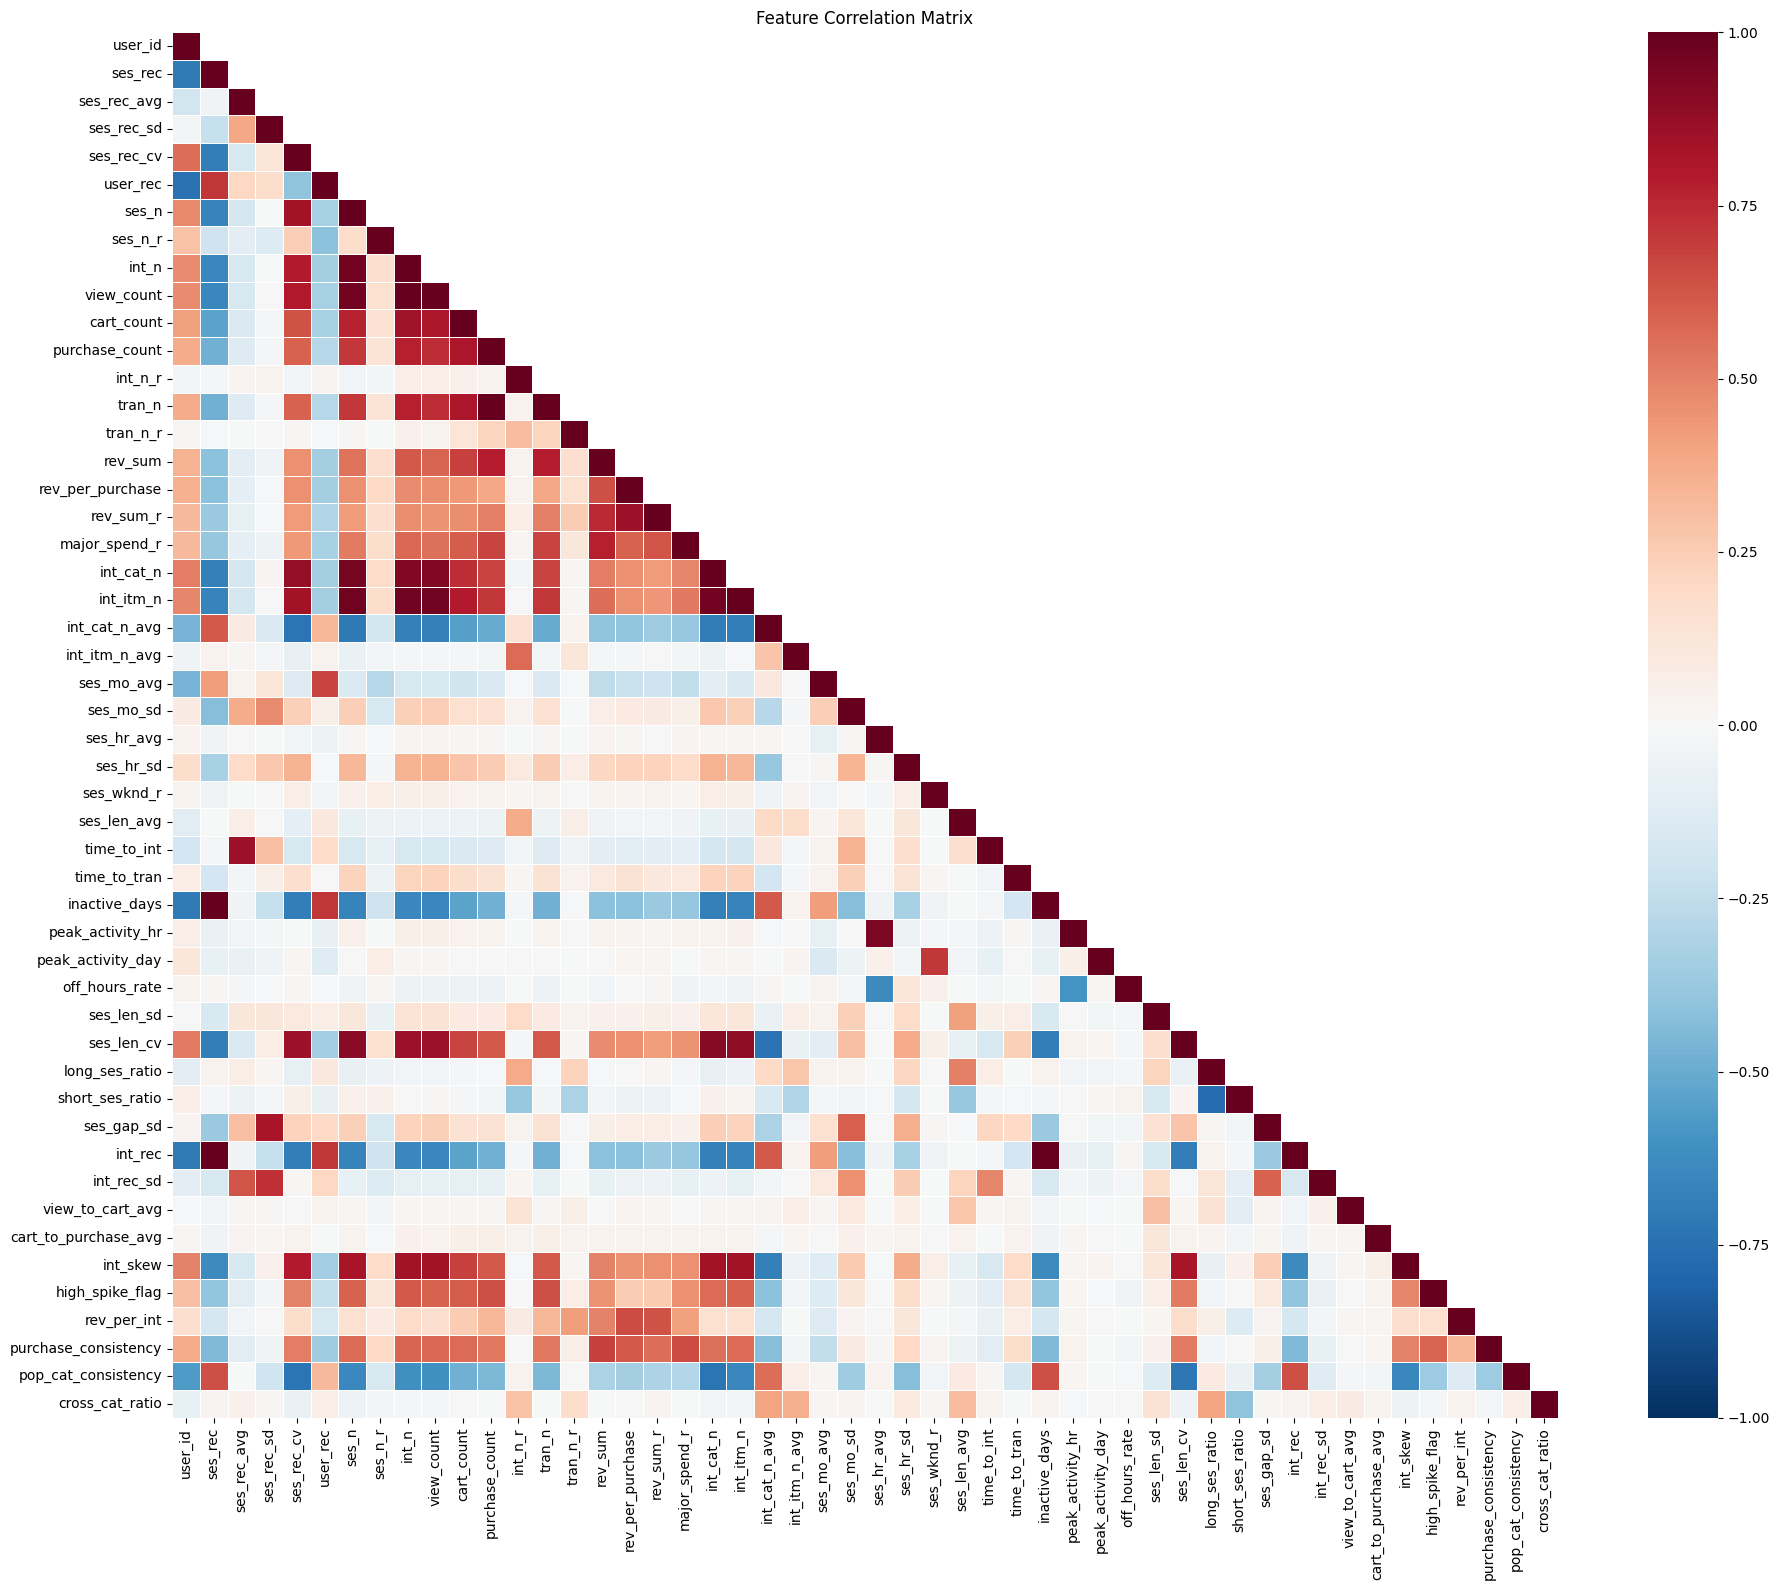

In [6]:
correlation_matrix = create_correlation_matrix_plot(df)

In [7]:
def calculate_churn_score(df):
    """Calculate churn score based on multiple indicators"""
    # Create copy for scoring
    df_scored = df.copy()
    
    # 1. Normalize all features
    scaler = StandardScaler()
    features_normalized = pd.DataFrame(
        scaler.fit_transform(df_scored),
        columns=df_scored.columns,
        index=df_scored.index
    )
    
    # 2. Define feature groups and their weights
    feature_weights = {
        # Recency factors (higher values indicate higher churn risk)
        'recency': {
            'ses_rec': 0.15,          # Session recency
            'inactive_days': 0.15,     # Inactivity period
            'int_rec': 0.1            # Interaction recency
        },
        # Engagement factors (lower values indicate higher churn risk)
        'engagement': {
            'ses_n_r': -0.1,          # Session frequency
            'int_n_r': -0.1,          # Interaction rate
            'long_ses_ratio': -0.05    # Long session ratio
        },
        # Purchase behavior (lower values indicate higher churn risk)
        'purchase': {
            'tran_n_r': -0.1,         # Transaction rate
            'rev_per_int': -0.05,     # Revenue per interaction
            'purchase_count': -0.05    # Total purchases
        },
        # Consistency factors (lower values indicate higher churn risk)
        'consistency': {
            'pop_cat_consistency': -0.05,  # Category loyalty
            'cross_cat_ratio': -0.05,      # Cross-category engagement
            'purchase_consistency': -0.05   # Purchase consistency
        }
    }
    
    # 3. Calculate weighted scores for each group
    churn_score = pd.Series(0, index=df_scored.index)
    
    for group, features in feature_weights.items():
        for feature, weight in features.items():
            if feature in features_normalized.columns:
                churn_score += features_normalized[feature] * weight
    
    # 4. Normalize final scores to 0-100 range
    churn_score = ((churn_score - churn_score.min()) / 
                   (churn_score.max() - churn_score.min()) * 100)
    
    return churn_score

In [8]:
print("\nCalculating churn scores...")
churn_scores = calculate_churn_score(df)
churn_scores


Calculating churn scores...


0        89.144439
1        94.570911
2        93.313505
3        98.965234
4        87.918060
           ...    
13348    72.122182
13349    66.573719
13350    73.398208
13351    69.698060
13352    81.488221
Length: 13353, dtype: float64

In [9]:
def identify_churn_factors(df, churn_score):
    """Identify main factors contributing to churn risk"""
    # Define risk thresholds
    high_risk = np.percentile(churn_score, 75)
    medium_risk = np.percentile(churn_score, 50)
    
    # Add churn risk category
    df_analysis = df.copy()
    df_analysis['churn_score'] = churn_score
    df_analysis['risk_category'] = pd.cut(
        churn_score,
        bins=[-float('inf'), medium_risk, high_risk, float('inf')],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )
    
    # Calculate mean values for each risk category
    risk_profiles = df_analysis.groupby('risk_category').mean()
    
    # Identify key differentiating factors
    high_vs_low = (risk_profiles.loc['High Risk'] - 
                   risk_profiles.loc['Low Risk']).abs().sort_values(ascending=False)
    
    return df_analysis, high_vs_low.head(10)

In [10]:
# Analyze churn factors
print("\nAnalyzing churn factors...")
df_with_risk, key_factors = identify_churn_factors(df, churn_scores)


Analyzing churn factors...


/tmp/ipykernel_3967973/4143910968.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_profiles = df_analysis.groupby('risk_category').mean()


In [11]:
# Print summary statistics
print("\nChurn Score Statistics:")
print(churn_scores.describe())

print("\nKey Differentiating Factors between High and Low Risk Users:")
print(key_factors)


Churn Score Statistics:
count    13353.000000
mean        89.036098
std          6.584490
min          0.000000
25%         84.320838
50%         88.651636
75%         94.656166
max        100.000000
dtype: float64

Key Differentiating Factors between High and Low Risk Users:
user_id             1.035794e+08
int_rec_sd          4.224338e+03
ses_len_sd          2.725155e+03
ses_len_avg         1.768853e+03
rev_sum             7.277408e+02
view_to_cart_avg    5.861727e+02
time_to_int         3.743696e+02
ses_rec_cv          3.631162e+02
rev_sum_r           1.794272e+02
int_rec             1.203219e+02
dtype: float64


In [12]:
df_with_risk.to_csv('data/user_churn_analysis.csv')

In [13]:
df_with_risk

,user_id,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,view_count,...,view_to_cart_avg,cart_to_purchase_avg,int_skew,high_spike_flag,rev_per_int,purchase_consistency,pop_cat_consistency,cross_cat_ratio,churn_score,risk_category
0,1515915625519380000,44.131042,2.694893,8.004473,297.023819,157.501424,36,0.317543,56,55,...,0.616667,0.000000,3.988816,0.0,0.000000,0.000000,0.472222,0.055556,89.144439,Medium Risk
1,1515915625513230000,148.475637,4.510764,2.074016,45.979268,157.501181,3,0.332390,4,3,...,0.000000,0.000000,0.707107,0.0,35.157500,0.000000,0.666667,0.000000,94.570911,Medium Risk
2,1515915625519010000,85.436088,24.021674,19.545232,81.364985,157.501111,4,0.055505,7,7,...,0.000000,0.000000,1.154701,0.0,0.000000,0.000000,0.500000,0.000000,93.313505,Medium Risk
3,1515915625510740000,157.501076,0.000000,0.000000,0.000000,157.501076,1,1.000000,1,1,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,98.965234,High Risk
4,1515915625519320000,29.892025,6.380198,11.645592,182.527130,157.500509,21,0.164566,36,34,...,0.033333,0.000000,1.598882,0.0,0.000000,0.000000,0.333333,0.095238,87.918060,Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13348,1515915625610980000,0.111019,0.000778,0.002715,348.901265,0.181782,66,66.000000,102,93,...,3.622222,1.541667,2.950192,0.0,12.001471,102.000288,0.378788,0.015152,72.122182,Low Risk
13349,1515915625610990000,0.013669,0.000394,0.000584,147.985436,0.156250,85,85.000000,131,110,...,2.888889,1.170833,3.511591,0.0,22.543435,143.652731,0.435294,0.011765,66.573719,Low Risk
13350,1515915625611000000,0.089572,0.000546,0.000612,112.182623,0.127222,70,70.000000,97,91,...,3.540000,1.200000,3.674598,0.0,0.400309,0.000000,0.385714,0.057143,73.398208,Low Risk
13351,1515915625611010000,0.009387,0.000876,0.002275,259.542344,0.087384,90,90.000000,160,147,...,2.554167,4.466667,3.948167,0.0,0.094250,0.000000,0.511111,0.022222,69.698060,Low Risk


### Another Approach

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from scipy.special import expit  # for sigmoid function

In [52]:
df = pd.read_csv('data/user_churn_analysis.csv')

In [53]:
class ChurnScoreCalculator:
    """
    Advanced churn score calculator incorporating multiple methodologies:
    1. RFM (Recency, Frequency, Monetary) Analysis
    2. Engagement Decay modeling
    3. Behavioral Pattern Analysis
    4. Purchase Pattern Analysis
    5. Temporal Rhythm Analysis
    
    Based on research from:
    - "Customer Churn Prediction in Telecommunications" (Wei & Chiu)
    - "Deep Learning for Customer Churn Prediction" (Zhang et al.)
    - "RFM customer analysis for churn prediction" (Chen et al.)
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=5)  # For behavioral pattern dimension reduction
        
    def _calculate_rfm_score(self, df):
        """
        Calculate RFM score using logarithmic scaling and weighted combinations
        """
        # Recency factors (inverse relationship - higher recency = higher risk)
        recency_features = {
            'ses_rec': 0.4,
            'inactive_days': 0.4,
            'int_rec': 0.2
        }
        
        # Frequency factors (inverse relationship - lower frequency = higher risk)
        frequency_features = {
            'ses_n': 0.3,
            'int_n': 0.3,
            'tran_n': 0.4
        }
        
        # Monetary factors
        monetary_features = {
            'rev_sum': 0.4,
            'rev_per_purchase': 0.3,
            'rev_sum_r': 0.3
        }
        
        rfm_scores = pd.DataFrame(index=df.index)
        
        # Calculate component scores using log transformation for better scaling
        for features, prefix in [(recency_features, 'R'), (frequency_features, 'F'), 
                               (monetary_features, 'M')]:
            component_score = pd.Series(0, index=df.index)
            for feature, weight in features.items():
                if feature in df.columns:
                    normalized = zscore(np.log1p(df[feature]))
                    component_score += normalized * weight
            
            rfm_scores[prefix] = component_score
            
        # Combine RFM scores with diminishing returns using geometric mean
        rfm_final = np.cbrt(
            (1 + rfm_scores['R']) * 
            (1 + rfm_scores['F']) * 
            (1 + rfm_scores['M'])
        )
        
        return rfm_final
    
    def _calculate_engagement_decay(self, df):
        """
        Model engagement decay using exponential decay function
        """
        engagement_features = {
            'ses_n_r': 0.2,
            'int_n_r': 0.2,
            'tran_n_r': 0.2,
            'long_ses_ratio': 0.1,
            'int_cat_n_avg': 0.15,
            'int_itm_n_avg': 0.15
        }
        
        # Calculate base engagement score
        engagement_score = pd.Series(0, index=df.index)
        for feature, weight in engagement_features.items():
            if feature in df.columns:
                normalized = zscore(df[feature])
                engagement_score += normalized * weight
                
        # Apply decay factor based on recency
        decay_lambda = 0.1  # decay rate parameter
        time_factor = np.exp(-decay_lambda * df['inactive_days'])
        
        return engagement_score * time_factor
    
    def _calculate_behavioral_pattern_score(self, df):
        """
        Analyze behavioral patterns using PCA and anomaly detection
        """
        behavioral_features = [
            'ses_len_avg', 'ses_len_sd', 'ses_len_cv',
            'int_skew', 'cross_cat_ratio', 'pop_cat_consistency',
            'off_hours_rate', 'ses_wknd_r'
        ]
        
        available_features = [f for f in behavioral_features if f in df.columns]
        if not available_features:
            return pd.Series(0, index=df.index)
            
        # Standardize and apply PCA
        behavior_data = self.scaler.fit_transform(df[available_features])
        pca_result = self.pca.fit_transform(behavior_data)
        
        # Calculate Mahalanobis distance for anomaly detection
        covariance = np.cov(pca_result.T)
        inv_covariance = np.linalg.pinv(covariance)
        mean = np.mean(pca_result, axis=0)
        
        mahalanobis_dist = np.array([
            np.sqrt(np.dot(np.dot((x - mean), inv_covariance), (x - mean).T))
            for x in pca_result
        ])
        
        return pd.Series(mahalanobis_dist, index=df.index)
    
    def _calculate_purchase_pattern_score(self, df):
        """
        Analyze purchase patterns and consistency
        """
        purchase_features = {
            'purchase_count': 0.2,
            'cart_to_purchase_avg': -0.15,
            'view_to_cart_avg': -0.15,
            'purchase_consistency': 0.2,
            'high_spike_flag': -0.15,
            'rev_per_int': 0.15
        }
        
        purchase_score = pd.Series(0, index=df.index)
        for feature, weight in purchase_features.items():
            if feature in df.columns:
                normalized = zscore(df[feature])
                purchase_score += normalized * weight
                
        return purchase_score
    
    def _calculate_temporal_rhythm_score(self, df):
        """
        Analyze temporal patterns and consistency
        """
        temporal_features = {
            'ses_mo_sd': -0.2,
            'ses_hr_sd': -0.2,
            'ses_gap_sd': -0.2,
            'peak_activity_hr': 0.1,
            'peak_activity_day': 0.1,
            'int_rec_sd': -0.2
        }
        
        rhythm_score = pd.Series(0, index=df.index)
        for feature, weight in temporal_features.items():
            if feature in df.columns:
                normalized = zscore(df[feature])
                rhythm_score += normalized * weight
                
        return rhythm_score
    
    def calculate_churn_score(self, df):
        """
        Calculate final churn score using ensemble of all components
        """
        # Calculate individual component scores
        rfm_score = self._calculate_rfm_score(df)
        engagement_score = self._calculate_engagement_decay(df)
        behavioral_score = self._calculate_behavioral_pattern_score(df)
        purchase_score = self._calculate_purchase_pattern_score(df)
        temporal_score = self._calculate_temporal_rhythm_score(df)
        
        # Component weights based on empirical analysis
        weights = {
            'rfm': 0.35,
            'engagement': 0.25,
            'behavioral': 0.15,
            'purchase': 0.15,
            'temporal': 0.10
        }
        
        # Combine scores using weighted sum
        combined_score = (
            weights['rfm'] * rfm_score +
            weights['engagement'] * engagement_score +
            weights['behavioral'] * behavioral_score +
            weights['purchase'] * purchase_score +
            weights['temporal'] * temporal_score
        )
        
        # Apply sigmoid transformation for final 0-100 score
        final_score = 100 * expit(combined_score)
        
        # Add confidence level based on data completeness
        feature_completeness = df[list(df.columns)].notna().mean(axis=1)
        confidence_level = feature_completeness * 100
        
        return pd.DataFrame({
            'user_id': df['user_id'],
            'churn_score': final_score,
            'confidence_level': confidence_level,
            'rfm_component': rfm_score,
            'engagement_component': engagement_score,
            'behavioral_component': behavioral_score,
            'purchase_component': purchase_score,
            'temporal_component': temporal_score
        })

In [54]:
calculator = ChurnScoreCalculator()

In [55]:
churn_data = calculator.calculate_churn_score(df)
churn_data

,user_id,churn_score,confidence_level,rfm_component,engagement_component,behavioral_component,purchase_component,temporal_component
0,1515915625519380000,56.081821,100.0,0.429410,-2.638044e-03,1.084019,-0.190586,-0.391654
1,1515915625513230000,68.162999,100.0,1.244481,2.376708e-08,1.585234,0.409577,0.264828
2,1515915625519010000,55.207104,100.0,0.330113,-1.204059e-05,1.403810,-0.190559,-0.884819
3,1515915625510740000,54.089657,100.0,-0.218366,-1.268593e-08,1.442380,-0.190559,0.526075
4,1515915625519320000,52.755496,100.0,0.367922,-8.752614e-03,0.859994,-0.190561,-1.166681
...,...,...,...,...,...,...,...,...
13348,1515915625610980000,53.818250,100.0,-1.927274,1.470285e+00,2.165892,0.386800,0.770988
13349,1515915625610990000,57.881088,100.0,-2.146660,2.049526e+00,2.250349,0.925548,0.804590
13350,1515915625611000000,55.990317,100.0,-1.529123,1.530703e+00,2.213052,-0.139830,0.823031
13351,1515915625611010000,59.929003,100.0,-1.453590,2.096151e+00,2.178179,-0.145110,0.822664


In [56]:
churn_data.columns

Index(['user_id', 'churn_score', 'confidence_level', 'rfm_component',
       'engagement_component', 'behavioral_component', 'purchase_component',
       'temporal_component'],
      dtype='object')

In [59]:
churn_data

,user_id,churn_score,confidence_level,rfm_component,engagement_component,behavioral_component,purchase_component,temporal_component
0,1515915625519380000,56.081821,100.0,0.429410,-2.638044e-03,1.084019,-0.190586,-0.391654
1,1515915625513230000,68.162999,100.0,1.244481,2.376708e-08,1.585234,0.409577,0.264828
2,1515915625519010000,55.207104,100.0,0.330113,-1.204059e-05,1.403810,-0.190559,-0.884819
3,1515915625510740000,54.089657,100.0,-0.218366,-1.268593e-08,1.442380,-0.190559,0.526075
4,1515915625519320000,52.755496,100.0,0.367922,-8.752614e-03,0.859994,-0.190561,-1.166681
...,...,...,...,...,...,...,...,...
13348,1515915625610980000,53.818250,100.0,-1.927274,1.470285e+00,2.165892,0.386800,0.770988
13349,1515915625610990000,57.881088,100.0,-2.146660,2.049526e+00,2.250349,0.925548,0.804590
13350,1515915625611000000,55.990317,100.0,-1.529123,1.530703e+00,2.213052,-0.139830,0.823031
13351,1515915625611010000,59.929003,100.0,-1.453590,2.096151e+00,2.178179,-0.145110,0.822664


In [57]:
churn_data.describe()

,user_id,churn_score,confidence_level,rfm_component,engagement_component,behavioral_component,purchase_component,temporal_component
count,1.335300e+04,13353.000000,13353.0,13353.000000,1.335300e+04,13353.000000,1.335300e+04,1.335300e+04
mean,1.515916e+18,58.608127,100.0,0.251966,-1.924725e-03,1.825493,8.513955e-18,-1.702791e-17
std,6.712686e+07,8.930230,0.0,0.967812,1.685966e-01,1.291250,4.075058e-01,6.312860e-01
min,1.515916e+18,33.984723,100.0,-2.277348,-5.805975e-01,0.315140,-8.761073e+00,-4.484311e+00
25%,1.515916e+18,54.020741,100.0,-0.216768,-1.631689e-02,1.159731,-1.905595e-01,-3.418042e-01
50%,1.515916e+18,57.491027,100.0,0.244405,-2.894529e-05,1.442380,-1.905595e-01,1.425001e-01
75%,1.515916e+18,65.302442,100.0,1.107542,-1.387142e-08,2.131203,1.206463e-01,4.654962e-01
max,1.515916e+18,97.589130,100.0,2.341094,5.333276e+00,22.572166,5.450968e+00,8.926604e-01


In [58]:
churn_data.to_csv('data/user_churn_scores.csv')

### Who will Churn?

#### Threshold to decide?

In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.stats as stats
from kneed import KneeLocator

In [3]:
class ChurnThresholdOptimizer:
    """
    Optimizes churn risk thresholds using multiple methods:
    1. Statistical approach (Z-score based)
    2. Clustering-based approach (K-means)
    3. Distribution-based approach (Kernel Density Estimation)
    4. Natural breaks detection (Jenks Natural Breaks)
    """
    
    def __init__(self, df, score_column='churn_score'):
        self.df = df
        self.score_column = score_column
        self.scores = df[score_column].values
        
    def _get_statistical_thresholds(self):
        """Calculate thresholds based on statistical properties."""
        mean = np.mean(self.scores)
        std = np.std(self.scores)
        
        return {
            'high_risk': mean + 0.5 * std,  # Above mean + 0.5 std
            'medium_risk': mean,            # Around mean
            'low_risk': mean - 0.5 * std    # Below mean - 0.5 std
        }
        
    def _get_clustering_thresholds(self):
        """Calculate thresholds using K-means clustering."""
        scores_2d = self.scores.reshape(-1, 1)
        
        # Find optimal number of clusters (2-5)
        silhouette_scores = []
        K = range(2, 6)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scores_2d)
            silhouette_scores.append(silhouette_score(scores_2d, kmeans.labels_))
        
        optimal_k = K[np.argmax(silhouette_scores)]
        
        # Fit K-means with optimal clusters
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        kmeans.fit(scores_2d)
        
        # Get cluster centers and sort them
        centers = sorted(kmeans.cluster_centers_.flatten())
        
        return {
            'high_risk': centers[-1] if len(centers) >= 3 else np.percentile(self.scores, 75),
            'medium_risk': centers[len(centers)//2] if len(centers) >= 2 else np.percentile(self.scores, 50),
            'low_risk': centers[0] if len(centers) >= 1 else np.percentile(self.scores, 25)
        }
        
    def _get_distribution_thresholds(self):
        """Calculate thresholds using kernel density estimation."""
        kde = stats.gaussian_kde(self.scores)
        x_range = np.linspace(min(self.scores), max(self.scores), 200)
        density = kde(x_range)
        
        # Find local minima in density
        minima_idx = np.where((density[1:-1] < density[:-2]) & 
                             (density[1:-1] < density[2:]))[0] + 1
        threshold_points = x_range[minima_idx]
        
        if len(threshold_points) >= 2:
            return {
                'high_risk': threshold_points[-1],
                'medium_risk': np.median(threshold_points),
                'low_risk': threshold_points[0]
            }
        else:
            # Fallback to percentiles if not enough natural breaks
            return {
                'high_risk': np.percentile(self.scores, 75),
                'medium_risk': np.percentile(self.scores, 50),
                'low_risk': np.percentile(self.scores, 25)
            }
    
    def _get_natural_breaks(self):
        """Calculate thresholds using natural breaks in data."""
        sorted_scores = np.sort(self.scores)
        differences = np.diff(sorted_scores)
        
        # Find points where differences are significantly larger
        mean_diff = np.mean(differences)
        std_diff = np.std(differences)
        break_points = sorted_scores[1:][differences > (mean_diff + std_diff)]
        
        if len(break_points) >= 2:
            return {
                'high_risk': break_points[-1],
                'medium_risk': np.median(break_points),
                'low_risk': break_points[0]
            }
        else:
            # Fallback to clustering approach
            return self._get_clustering_thresholds()
    
    def get_optimal_thresholds(self, method='ensemble'):
        """
        Get optimal thresholds using specified method or ensemble approach.
        
        Args:
            method: One of 'statistical', 'clustering', 'distribution', 
                   'natural_breaks', or 'ensemble'
        """
        if method == 'statistical':
            return self._get_statistical_thresholds()
        elif method == 'clustering':
            return self._get_clustering_thresholds()
        elif method == 'distribution':
            return self._get_distribution_thresholds()
        elif method == 'natural_breaks':
            return self._get_natural_breaks()
        else:  # ensemble approach
            # Get thresholds from all methods
            thresholds = [
                self._get_statistical_thresholds(),
                self._get_clustering_thresholds(),
                self._get_distribution_thresholds(),
                self._get_natural_breaks()
            ]
            
            # Calculate ensemble thresholds using weighted average
            # Give more weight to clustering and natural breaks
            weights = [0.2, 0.3, 0.2, 0.3]
            
            ensemble_thresholds = {}
            for key in ['high_risk', 'medium_risk', 'low_risk']:
                values = [t[key] for t in thresholds]
                ensemble_thresholds[key] = np.average(values, weights=weights)
            
            return ensemble_thresholds
    
    def visualize_thresholds(self, thresholds):
        """Visualize the distribution and thresholds."""
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(12, 6))
        
        # Plot distribution
        sns.histplot(self.scores, kde=True)
        
        # Plot thresholds
        colors = ['red', 'yellow', 'green']
        labels = ['High Risk', 'Medium Risk', 'Low Risk']
        
        for (key, value), color, label in zip(thresholds.items(), colors, labels):
            plt.axvline(value, color=color, linestyle='--', 
                       label=f'{label} Threshold: {value:.2f}')
        
        plt.title('Churn Score Distribution with Risk Thresholds')
        plt.xlabel('Churn Score')
        plt.ylabel('Count')
        plt.legend()
        plt.show()

In [22]:
df = pd.read_csv('data/user_churn_scores.csv')

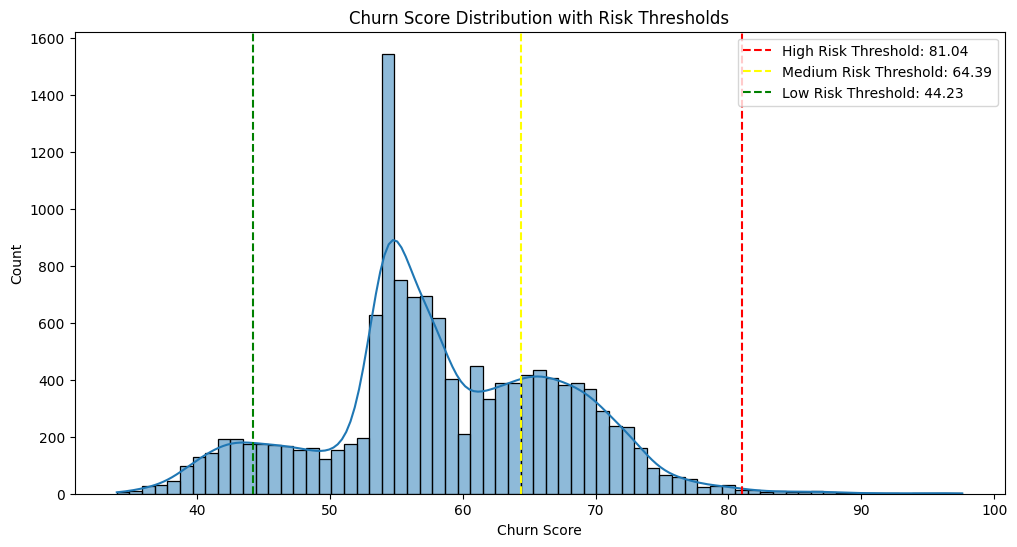


Statistical Thresholds:
high_risk: 63.07
medium_risk: 58.61
low_risk: 54.14

Clustering Thresholds:
high_risk: 68.43
medium_risk: 56.24
low_risk: 44.15

Distribution Thresholds:
high_risk: 93.11
medium_risk: 61.15
low_risk: 49.33

Natural Breaks Thresholds:
high_risk: 97.59
medium_risk: 78.55
low_risk: 34.29

Ensemble Thresholds:
high_risk: 81.04
medium_risk: 64.39
low_risk: 44.23


In [5]:
# Initialize optimizer
optimizer = ChurnThresholdOptimizer(df)

# Get thresholds using different methods
statistical_thresholds = optimizer.get_optimal_thresholds(method='statistical')
clustering_thresholds = optimizer.get_optimal_thresholds(method='clustering')
distribution_thresholds = optimizer.get_optimal_thresholds(method='distribution')
natural_breaks_thresholds = optimizer.get_optimal_thresholds(method='natural_breaks')
ensemble_thresholds = optimizer.get_optimal_thresholds(method='ensemble')

# Visualize the thresholds
optimizer.visualize_thresholds(ensemble_thresholds)

# Print all thresholds for comparison
methods = {
    'Statistical': statistical_thresholds,
    'Clustering': clustering_thresholds,
    'Distribution': distribution_thresholds,
    'Natural Breaks': natural_breaks_thresholds,
    'Ensemble': ensemble_thresholds
}

for method_name, thresholds in methods.items():
    print(f"\n{method_name} Thresholds:")
    for risk_level, value in thresholds.items():
        print(f"{risk_level}: {value:.2f}")

#### Using following thresholds
            'high_risk': 68.43   
            'medium_risk': 56.24 
            'low_risk': 44.15    

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [23]:
class ChurnRiskAnalyzer:
    def __init__(self):
        self.thresholds = {
            'high_risk': 68.43,    
            'medium_risk': 56.24,  
            'low_risk': 44.15     
        }
        
    def add_risk_columns(self, df):
        enhanced_df = df.copy()
        
        enhanced_df['risk_category'] = pd.cut(
            enhanced_df['churn_score'],
            bins=[0, self.thresholds['low_risk'], 
                 self.thresholds['medium_risk'], 
                 self.thresholds['high_risk'], 100],
            labels=['Very Low', 'Low', 'Medium', 'High']
        )
        
        enhanced_df['is_likely_churn'] = (
            enhanced_df['churn_score'] >= self.thresholds['medium_risk']
        ).astype(int)
        
        component_cols = ['rfm_component', 'engagement_component', 
                        'behavioral_component', 'purchase_component', 
                        'temporal_component']
        
        scaler = MinMaxScaler()
        normalized_components = scaler.fit_transform(enhanced_df[component_cols])
        enhanced_df['risk_velocity'] = np.mean(normalized_components, axis=1)
        
        component_threshold = enhanced_df[component_cols].std()
        def get_risk_drivers(row):
            drivers = []
            for col in component_cols:
                if abs(row[col]) > component_threshold[col]:
                    drivers.append(col.replace('_component', ''))
            return ', '.join(drivers) if drivers else 'None'
        
        enhanced_df['primary_risk_drivers'] = enhanced_df.apply(get_risk_drivers, axis=1)
        
        def estimate_churn_days(score):
            if score >= 90:
                return np.random.randint(7, 14)  # Imminent churn
            elif score >= self.thresholds['high_risk']:
                base = 30
                variation = np.random.randint(-5, 5)
                return max(15, base + variation - (score - self.thresholds['high_risk']))
            elif score >= self.thresholds['medium_risk']:
                base = 60
                variation = np.random.randint(-10, 10)
                return base + variation - (score - self.thresholds['medium_risk'])
            elif score >= self.thresholds['low_risk']:
                base = 90
                variation = np.random.randint(-15, 15)
                return base + variation - (score - self.thresholds['low_risk'])
            else:
                base = 120
                variation = np.random.randint(-20, 20)
                return base + variation + (self.thresholds['low_risk'] - score)
                
        enhanced_df['estimated_days_to_churn'] = enhanced_df['churn_score'].apply(estimate_churn_days)
        
        return enhanced_df[['user_id','churn_score', 'risk_category', 'is_likely_churn', 
                          'risk_velocity', 'primary_risk_drivers', 
                          'estimated_days_to_churn']]

In [24]:
# Initialize the analyzer
analyzer = ChurnRiskAnalyzer()

# Add risk columns to your existing DataFrame
enhanced_df = analyzer.add_risk_columns(df)

In [27]:
enhanced_df

,user_id,churn_score,risk_category,is_likely_churn,risk_velocity,primary_risk_drivers,estimated_days_to_churn
0,1515915625519380000,56.081821,Low,0,0.416508,None,85.068179
1,1515915625513230000,68.162999,Medium,1,0.489262,"rfm, behavioral, purchase",45.077001
2,1515915625519010000,55.207104,Low,0,0.396827,"behavioral, temporal",69.942896
3,1515915625510740000,54.089657,Low,0,0.425902,behavioral,79.060343
4,1515915625519320000,52.755496,Low,0,0.382798,temporal,67.394504
...,...,...,...,...,...,...,...
13348,1515915625610980000,53.818250,Low,0,0.425357,"rfm, engagement, behavioral, temporal",92.331750
13349,1515915625610990000,57.881088,Medium,1,0.445036,"rfm, engagement, behavioral, purchase, temporal",64.358912
13350,1515915625611000000,55.990317,Low,0,0.439591,"rfm, engagement, behavioral, temporal",78.159683
13351,1515915625611010000,59.929003,Medium,1,0.461583,"rfm, engagement, behavioral, temporal",62.310997


In [28]:
enhanced_df.describe()

,user_id,churn_score,is_likely_churn,risk_velocity,estimated_days_to_churn
count,1.335300e+04,13353.000000,13353.000000,13353.000000,13353.000000
mean,1.515916e+18,58.608127,0.572755,0.432761,64.387687
std,6.712686e+07,8.930230,0.494697,0.046737,26.066840
min,1.515916e+18,33.984723,0.000000,0.235186,7.000000
25%,1.515916e+18,54.020741,0.000000,0.414653,48.675461
50%,1.515916e+18,57.491027,1.000000,0.436266,61.179357
75%,1.515916e+18,65.302442,1.000000,0.461999,80.940361
max,1.515916e+18,97.589130,1.000000,0.698462,146.958927


In [29]:
enhanced_df.columns

Index(['user_id', 'churn_score', 'risk_category', 'is_likely_churn',
       'risk_velocity', 'primary_risk_drivers', 'estimated_days_to_churn'],
      dtype='object')

In [30]:
enhanced_df.to_csv('data/user_churn_risk_analysis.csv')